# Film recommendation engine based on my history list from Trakt.tv

> This notebook aims at building a recommendation engine from the content of my history list that contains around 1000 movies.

Recommendation engines are of three kinds :
* **popularity-based** : the most simple be also the most impersonal
* **content-based** : the recommendations are based on the description of the products
* **collaborative filtering** : records from various users provide recommendations based on user similarities

Now, I only will focus on the content and popularity of the films, thus collaborative filtering is excluded.

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
plt.style.use('seaborn')
%matplotlib inline

from wordcloud import WordCloud

import pandas as pd
import numpy as np

from collections import Counter
import requests
import json
import time

from backports import configparser

config = configparser.ConfigParser()
config.read('config.ini')

CLIENT_ID = config.get('TRAKT','CLIENT_ID')
CLIENT_SECRET = config.get('TRAKT','CLIENT_SECRET')
OAUTH_TOKEN = config.get('TRAKT','OAUTH_TOKEN')

headers = {
  'Content-Type': 'application/json',
  'trakt-api-version': '2',
  'trakt-api-key': CLIENT_ID
}

## Get Data

In [ ]:
# user slug
user_id = 'synyss' 

# Get extended info
history = 'https://api.trakt.tv/users/{}/history/movies?limit=1000&extended=full'.format(user_id)
resp = requests.get(history, headers=headers)

response_body = resp.json()
len(response_body)
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body[0], indent=2))

In [ ]:
df = pd.DataFrame()

for data in response_body:
    df = df.append({
            'title' : data['movie']['title'],
            'year' : data['movie']['year'],
            'watched_at' : data['watched_at'],
            'ids' : data['movie']['ids'],
            'tagline' : data['movie']['tagline'],
            'overview' : data['movie']['overview'],
            'released' : data['movie']['released'],
            'duration' : data['movie']['runtime'],
            'country' : data['movie']['country'],
            'rating' : data['movie']['rating'],
            'votes' : data['movie']['votes'],
            'language' : data['movie']['language'],
            'genres' : data['movie']['genres'],
            'certification' : data['movie']['certification']
        }, ignore_index=True)
    
df.to_csv('data/movies_history.csv', index=False)

In [2]:
df = pd.read_csv('data/movies_history.csv')

In [3]:
df = df.drop_duplicates(subset='ids')

In [4]:
df.head()

,certification,country,duration,genres,ids,language,overview,rating,released,tagline,title,votes,watched_at,year
0,R,us,102.0,"['drama', 'romance', 'comedy']","{'trakt': 118, 'slug': 'lost-in-translation-20...",en,"Two lost souls visiting Tokyo -- the young, ne...",7.68716,2003-09-18,Everyone wants to be found.,Lost in Translation,7189.0,2020-03-10T19:09:00.000Z,2003.0
1,R,us,137.0,"['action', 'science-fiction', 'drama', 'superh...","{'trakt': 161972, 'slug': 'logan-2017', 'imdb'...",en,"In the near future, a weary Logan cares for an...",7.98986,2017-03-03,His time has come,Logan,54447.0,2020-03-09T20:25:00.000Z,2017.0
2,PG-13,us,106.0,"['action', 'adventure', 'comedy']","{'trakt': 4757, 'slug': 'charlie-s-angels-full...",en,The Angels are charged with finding a pair of ...,5.80007,2003-06-27,This summer the Angels are back.,Charlie's Angels: Full Throttle,2811.0,2020-03-08T20:08:21.000Z,2003.0
3,PG-13,us,98.0,"['action', 'adventure', 'comedy', 'crime', 'th...","{'trakt': 2541, 'slug': 'charlie-s-angels-2000...",en,"Three women, detectives with a mysterious boss...",6.12826,2000-11-02,Get Some Action,Charlie's Angels,4288.0,2020-03-08T20:08:12.000Z,2000.0
4,NaN,us,108.0,"['drama', 'romance']","{'trakt': 221327, 'slug': 'all-the-bright-plac...",en,Two teens facing personal struggles form a pow...,7.04950,2020-02-28,Live life at full brightness,All the Bright Places,404.0,2020-03-08T19:59:00.000Z,2020.0


In [5]:
import ast # because of string representation of list

def listToString(s):
    '''for convenient print of genre'''
    str1 = "|"
    return (str1.join(s))

df['genres'] =  df['genres'].apply(lambda x : listToString(ast.literal_eval(x)))

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 906 entries, 0 to 918
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   certification  809 non-null    object 
 1   country        896 non-null    object 
 2   duration       905 non-null    float64
 3   genres         906 non-null    object 
 4   ids            906 non-null    object 
 5   language       905 non-null    object 
 6   overview       906 non-null    object 
 7   rating         906 non-null    float64
 8   released       904 non-null    object 
 9   tagline        791 non-null    object 
 10  title          906 non-null    object 
 11  votes          906 non-null    float64
 12  watched_at     906 non-null    object 
 13  year           904 non-null    float64
dtypes: float64(4), object(10)
memory usage: 106.2+ KB


In [7]:
df[df['year'].isnull()]

,certification,country,duration,genres,ids,language,overview,rating,released,tagline,title,votes,watched_at,year
378,NaN,us,46.0,documentary,"{'trakt': 394186, 'slug': 'inside-medical-mari...",en,"In Northern California's Emerald Triangle, mor...",9.00000,NaN,NaN,Inside: Medical Marijuana,1.0,2019-08-27T18:36:11.000Z,NaN
666,NaN,NaN,0.0,,"{'trakt': 228037, 'slug': 'dragon-ball-super',...",ja,"With Majin Boo defeated, peace returns to Eart...",8.08871,NaN,Doragon Bōru Sūpā,Dragon Ball Super,124.0,2018-11-12T19:55:32.000Z,NaN


In [8]:
# drop dragon-ball-super and 2011 for inside-medical-marijuana

df.drop([666], inplace=True)

df.at[378, 'year'] = 2011

In [9]:
df = df.astype({'year': int})

In [10]:
df.describe()

,duration,rating,votes,year
count,904.000000,905.000000,905.000000,905.000000
mean,110.085177,7.034109,10175.738122,2008.075138
std,25.157894,0.836851,10982.853958,8.847459
min,0.000000,3.116580,1.000000,1968.000000
25%,96.000000,6.538570,2213.000000,2004.000000
50%,109.000000,7.083860,6526.000000,2010.000000
75%,124.000000,7.625780,14467.000000,2015.000000
max,201.000000,9.500000,84750.000000,2020.000000


## Exploration

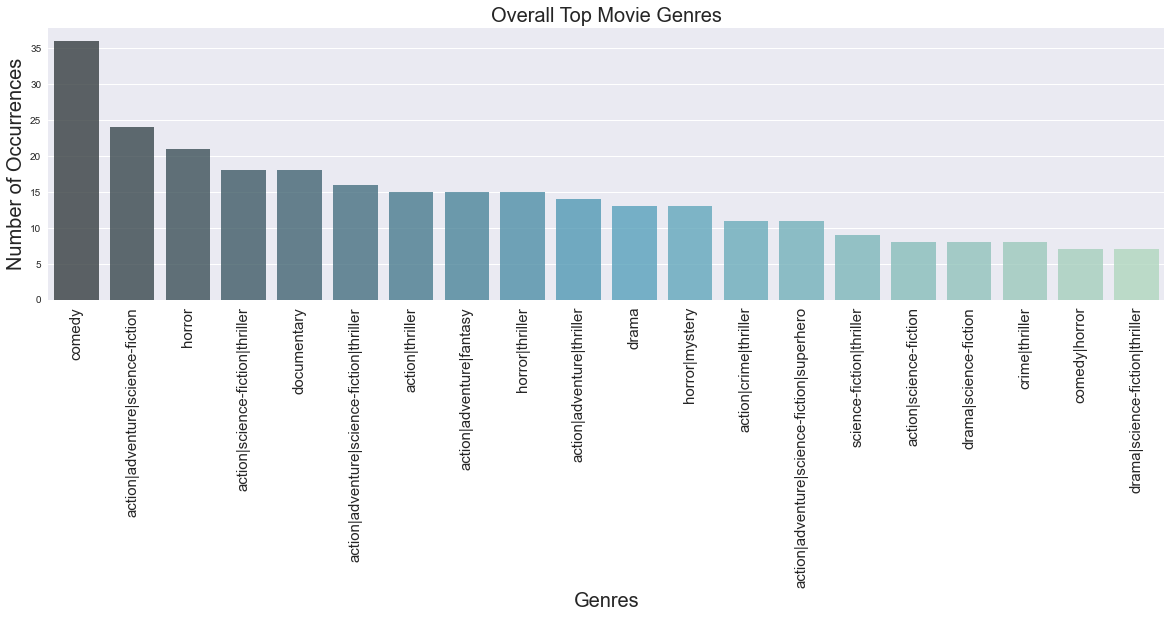

In [11]:
top_genres = df['genres'].value_counts(normalize=False)
top_genres = top_genres[:20,]

plt.figure(figsize=(20,5))

sns.barplot(top_genres.index, top_genres.values, alpha=0.8, palette='GnBu_d')

plt.title('Overall Top Movie Genres', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(rotation=90, fontsize=15)
plt.show()

In [12]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    for s in liste: keyword_count[s] = 0
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_occurences, keyword_count

In [13]:
genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences, dum = count_word(df, 'genres', genre_labels)
keyword_occurences[:3]

[['action', 423], ['thriller', 327], ['science-fiction', 315]]

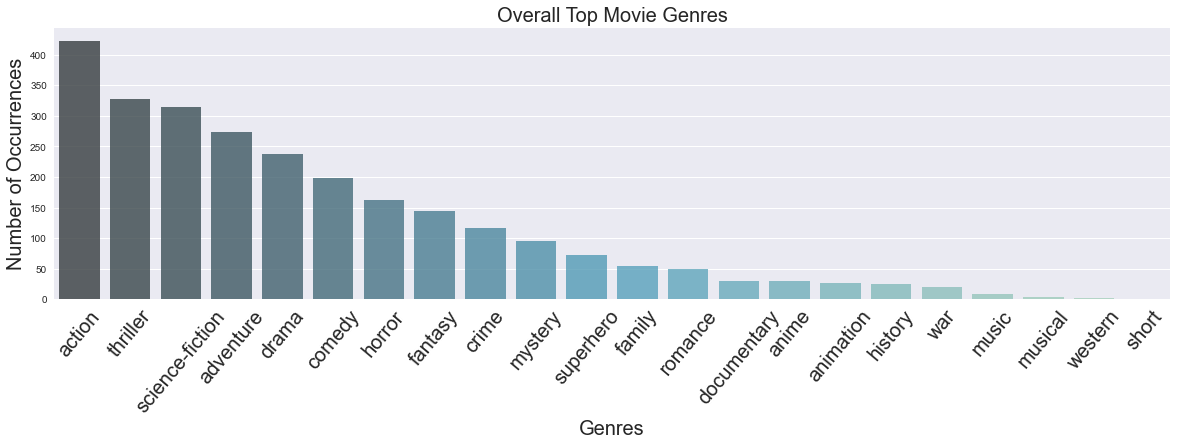

In [14]:
plt.figure(figsize=(20,5))
labels, ys = zip(*keyword_occurences)
xs = np.arange(len(labels)) 

sns.barplot(xs, ys, alpha=0.8, palette='GnBu_d')

plt.title('Overall Top Movie Genres', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Genres', fontsize=20)
plt.xticks(xs,labels, rotation=50, fontsize=20)
plt.show()

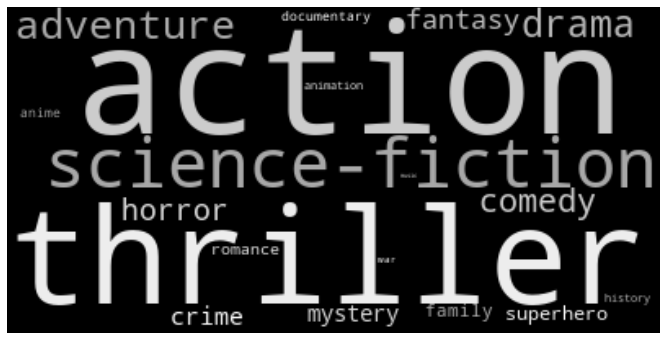

In [15]:
import random

def grey_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(60, 100)

words = dict()
for s in keyword_occurences:
    words[s[0]] = s[1]

f, ax = plt.subplots(figsize=(20, 6))

wordcloud = WordCloud(color_func=grey_color_func)
wordcloud.generate_from_frequencies(words)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

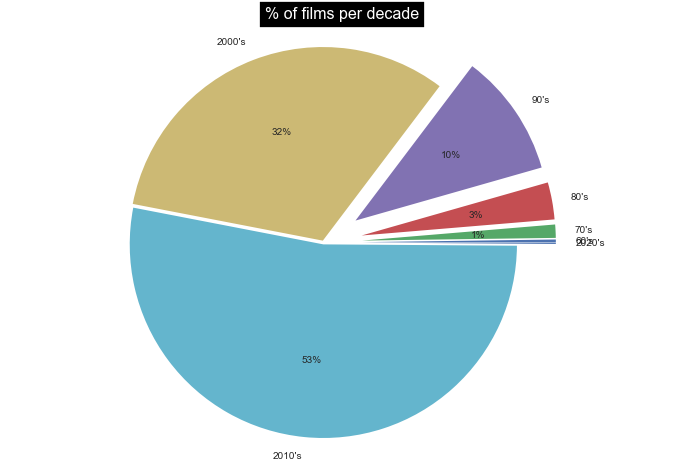

In [16]:
df['decade'] = df['year'].apply(lambda x:((x-1900)//10)*10)

# function that extract statistical parameters from a grouby objet:
def get_stats(gr):
    return {'min':gr.min(),'max':gr.max(),'count': gr.count(),'mean':gr.mean()}

# Creation of a dataframe with statitical infos on each decade:
test = df['year'].groupby(df['decade']).apply(get_stats).unstack()

# funtion used to set the labels
def label(s):
    val = (1900 + s, s)[s < 100]
    chaine = '' if s < 50 else "{}'s".format(int(val))
    return chaine

f, ax = plt.subplots(figsize=(12, 8))

labels = [label(s) for s in  test.index]
sizes  = test['count'].values
explode = [0.2 if sizes[i] < 100 else 0.01 for i in range(7)]

ax.pie(sizes, explode = explode, labels=labels,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       )
ax.axis('equal')
ax.set_title('% of films per decade',
             bbox={'facecolor':'k', 'pad':5}, color='w', fontsize=16);

df.drop('decade', axis=1, inplace = True)

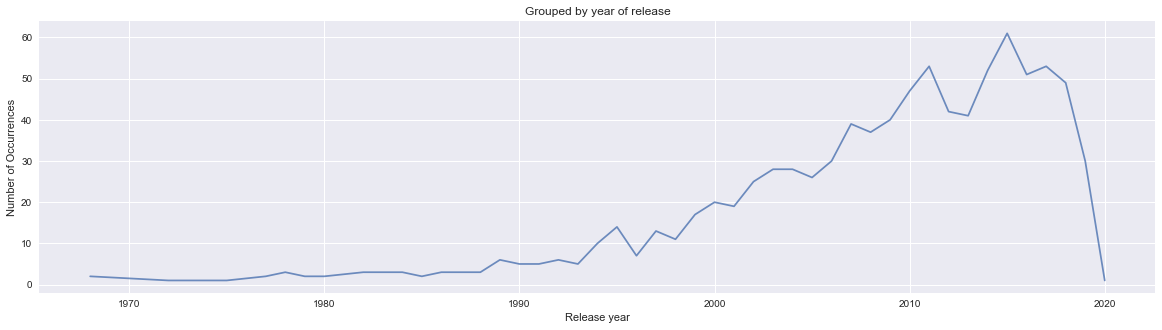

In [17]:
data = df['year'].value_counts().sort_index()

plt.figure(figsize=(20,5))

sns.lineplot(data.index, data.values, alpha=0.8, palette='GnBu_d')

plt.title('Grouped by year of release')
plt.ylabel('Number of Occurrences')
plt.xlabel('Release year')
plt.show()

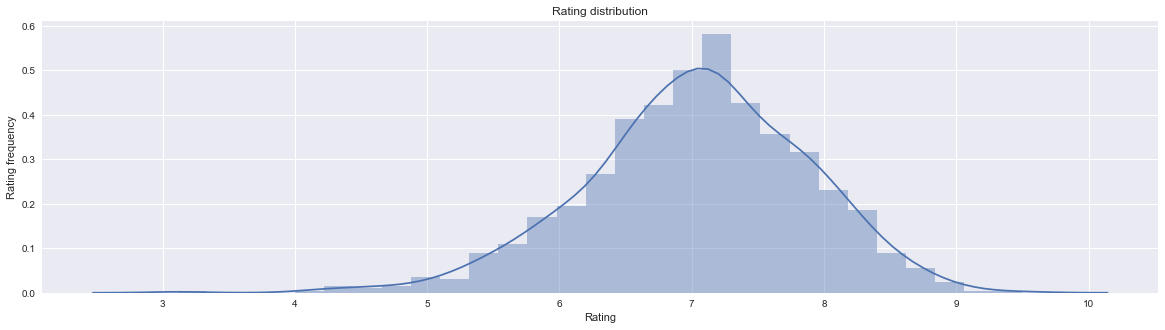

In [18]:
data = df['rating']

plt.figure(figsize=(20,5))

sns.distplot(data)

plt.title('Rating distribution')
plt.ylabel('Rating frequency')
plt.xlabel('Rating')
plt.show()

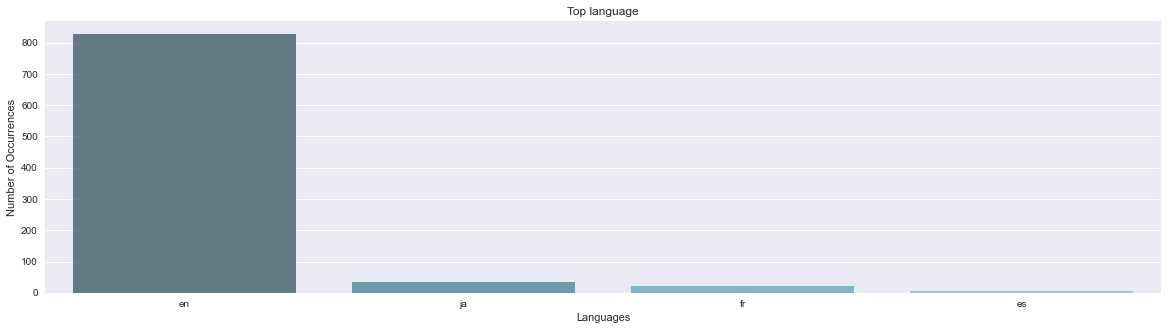

In [19]:
data = df['language'].value_counts(normalize=False)
data = data[:4,]

plt.figure(figsize=(20,5))

g = sns.barplot(data.index, data.values, alpha=0.8, palette='GnBu_d')

plt.title('Top language')
plt.ylabel('Number of Occurrences')
plt.xlabel('Languages')
plt.xticks()
plt.show()

In [20]:
def count_word(df, ref_col, liste):
    keyword_count = dict()
    
    for s in liste: keyword_count[s] = 0
        
    for liste_keywords in df[ref_col].str.split('|'):        
        if type(liste_keywords) == float and pd.isnull(liste_keywords): continue        
        for s in [s for s in liste_keywords if s in liste]: 
            if pd.notnull(s): keyword_count[s] += 1

    # convert the dictionary in a list to sort the keywords by frequency
    keyword_occurences = []
    for k,v in keyword_count.items():
        keyword_occurences.append([k,v])
    keyword_occurences.sort(key = lambda x:x[1], reverse = True)
    return keyword_count

In [21]:
def most_common_inclusive(freq_dict):
    # find the nth most common value
    nth_most_common = sorted(freq_dict.values(), reverse=True)[0]
    return { k: v for k, v in freq_dict.items() if v >= nth_most_common }

genre_labels = set()
for s in df['genres'].str.split('|').values:
    genre_labels = genre_labels.union(set(s))

keyword_occurences = count_word(df, 'genres', genre_labels)

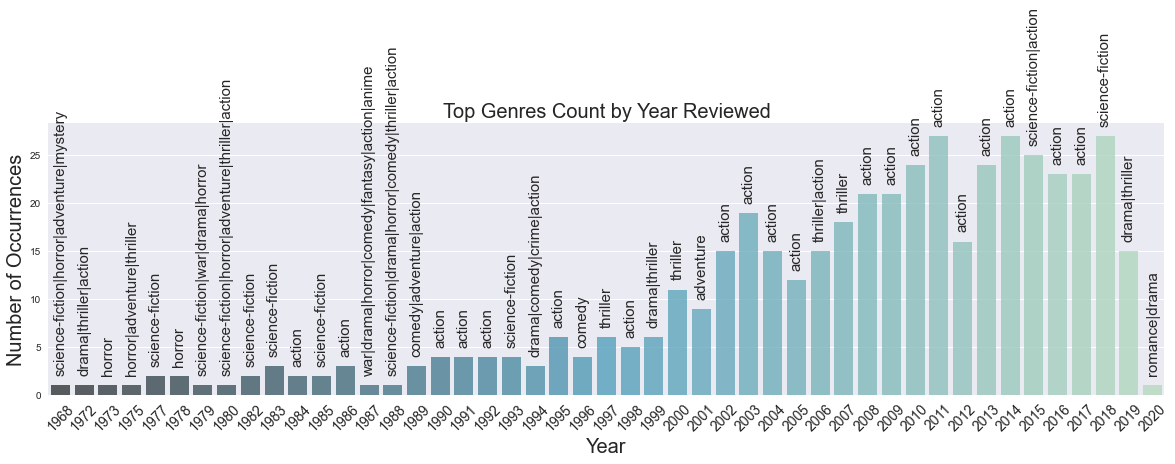

In [22]:
reviews_by_genres = df.groupby(['year']).apply(lambda x : count_word(x, 'genres', genre_labels)).reset_index()
reviews_by_genres[0] = reviews_by_genres[0].apply(most_common_inclusive)
reviews_by_genres['genres'] = reviews_by_genres[0].apply(lambda dict1 : '|'.join(x for x in dict1.keys()))
reviews_by_genres['counts'] = reviews_by_genres[0].apply(lambda dict1: list(dict1.values())[0])
reviews_by_genres.drop([0], axis=1, inplace=True)

plt.figure(figsize=(20,5))

g = sns.barplot(reviews_by_genres['year'], reviews_by_genres['counts'], alpha=0.8, palette='GnBu_d')

plt.title('Top Genres Count by Year Reviewed', fontsize=20)
plt.ylabel('Number of Occurrences', fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.xticks(rotation=45, fontsize=14)


for index, row in reviews_by_genres.iterrows():
    g.text(row.name, row.counts + 1, row.genres, ha="center", rotation=90, 
           verticalalignment='bottom', fontsize=15)

plt.show()

In [23]:
df['description'] = df['tagline'] + ' ' + df['overview']
df['description'] = df['description'].fillna(' ')

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(analyzer='word',ngram_range=(1, 3),min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(df['description'])

freqs = {word : tfidf_matrix.getcol(idx).sum() for word, idx in tf.vocabulary_.items()}


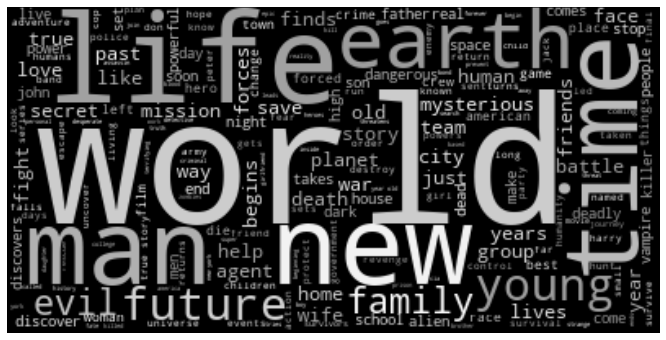

In [25]:
f, ax = plt.subplots(figsize=(20,6))

wordcloud = WordCloud(color_func=grey_color_func)
wordcloud.generate_from_frequencies(freqs)

plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

## Recommendation 

There is a lot of different way to recommend movie. The first method I will use is to make suggestions like "I watched this, so I might also be interested in that". I would really enjoy if when I scroll in my favorite app, I can click on my recently watched movie and access to similar movie.

A solution for this problem is to train a movie embedded model using meta information.

With the Trakt API we can't easy get meta data about movie like top-3 actors, director, writer and box-office. Thus, we will use the IMDBPY API (the official API of IMDb is undocumented)

Here we will use the most 10 000 popular movies according to Trakt. (Popularity is calculated using the rating percentage and the number of ratings.) Clearly not the best list of movies but it's a pretty good start.

In [26]:
# Get populer movies

headers = {
    'Content-Type': 'application/json',
    'trakt-api-version': '2',
    'trakt-api-key': CLIENT_ID
}

pop = 'https://api.trakt.tv/movies/popular?limit=10000'

resp = requests.get(pop, headers=headers)

response_body = resp.json()
len(response_body)
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body[0], indent=2))

{
  "title": "Deadpool",
  "year": 2016,
  "ids": {
    "trakt": 190430,
    "slug": "deadpool-2016",
    "imdb": "tt1431045",
    "tmdb": 293660
  }
}


In [27]:
top_movies = pd.DataFrame()

for movie in response_body :
    top_movies = top_movies.append({
                        'title' : movie['title'],
                        'year' : movie['year'],
                        'imdb' : movie['ids']['imdb']
                            }, ignore_index=True)
    
top_movies.to_csv('data/top_10000_movies.csv', index=False)

In [28]:
top_movies = pd.read_csv('data/top_10000_movies.csv')
top_movies.head()

,imdb,title,year
0,tt1431045,Deadpool,2016.0
1,tt2015381,Guardians of the Galaxy,2014.0
2,tt0468569,The Dark Knight,2008.0
3,tt1375666,Inception,2010.0
4,tt3315342,Logan,2017.0


In [29]:
top_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   imdb    9988 non-null   object 
 1   title   10000 non-null  object 
 2   year    9999 non-null   float64
dtypes: float64(1), object(2)
memory usage: 234.5+ KB


In [30]:
from imdb import IMDb

# create an instance of the IMDb class
ia = IMDb()


In [68]:
# Manage KeyError
from contextlib import suppress


class GetMovieDetails(object):

    def __init__(self, movie):
        
        self.movie = movie

    def get_details(self, info_type):
        
        return self.movie.get(info_type)

    def movie_details(self):
        
        movie_details = {}
        
        movie_details['title'] = '-' if self.get_details('title') is None \
                                    else self.get_details('title')
        
        movie_details['year'] = '-' if self.get_details('year') is None \
                                    else self.get_details('year')
                                      
        movie_details['genres'] = '|'.join('-' if self.get_details('genres') is None \
                                                else self.get_details('genres'))

        movie_details['languages'] = ', '.join('-' if self.get_details('languages') is None \
                                                    else self.get_details('languages'))
        
        movie_details['runtimes'] = '-' if self.get_details('runtimes') is None \
                                        else self.get_details('runtimes')
        
        movie_details['rating'] = '-' if self.get_details('rating') is None \
                                    else self.get_details('rating')
        
        movie_details['votes'] = '-' if self.get_details('votes') is None \
                                    else self.get_details('votes')
        
        movie_details['director'] = ', '.join('-' if self.get_details('director') is None \
                                                else [i['name'] for i in list(self.get_details('director'))])
        
        movie_details['writers'] = ', '.join('-' if self.get_details('writers') is None \
                                                else [i['name'] for i in list(self.get_details('writers'))])        
        
        movie_details['cast'] = ', '.join('-' if self.get_details('cast') is None \
                                              else [i['name'] for i in list(self.get_details('cast'))])

        movie_details['composers'] = '-' if self.get_details('composers') is None \
                                        else self.get_details('composers')[0]['name']

        movie_details['plot'] = '-' if self.get_details('plot') is None \
                                    else self.get_details('plot')[0]

        movie_details['plot_outline'] = '-' if self.get_details('plot outline') is None \
                                            else self.get_details('plot outline')

        movie_details['cover_url'] = '-' if self.get_details('cover url') is None \
                                         else self.get_details('cover url')
        
        movie_details['full_size_cover_url'] = '-' if self.get_details('full-size cover url') is None \
                                                 else self.get_details('full-size cover url')
        
        movie_details['box_office'] = ', '.join('-' if self.get_details('box office') is None \
                                                    else {k + " - " + v for k, v in self.get_details('box office').items()})
        
        # movie_details['synopsis'] = '-' if self.get_details('synopsis') is None \
        #                               else self.get_details('synopsis')[0]
        
        return movie_details

In [33]:
top_movies['imdb'][:100]

0     tt1431045
1     tt2015381
2     tt0468569
3     tt1375666
4     tt3315342
        ...    
95    tt2527336
96    tt2660888
97    tt0373889
98    tt0114369
99    tt0974015
Name: imdb, Length: 100, dtype: object

In [37]:
movie_id = '1431045'
movie = ia.get_movie(movie_id, info=('main', 'plot'))

movie_details_obj = GetMovieDetails(movie)
movie_details_dict = movie_details_obj.movie_details()

df = pd.DataFrame(columns=movie_details_dict.keys())
error = []


for idIMDB in top_movies['imdb'][:100]:
    
    try : 
        movie = ia.get_movie(idIMDB[2:], info=('main', 'plot'))

        movie_details_obj = GetMovieDetails(movie)
        movie_details_dict = movie_details_obj.movie_details()

        movie_set = pd.DataFrame.from_dict(movie_details_dict)
        df = pd.concat([df, movie_set], axis =0, sort=False)

    except :
        print(idIMDB)
        error.append(idIMDB)
    
    time.sleep(2)    
    

df.to_csv('data/info_extended_top_10000.csv', index=False)

tt2015381
tt0468569
tt3315342
tt0848228
tt1211837
tt1386697
tt0451279
tt3498820
tt2543164
tt3896198
tt2488496
tt3521164
tt2294629
tt0371746
tt3659388
tt0120737
tt2250912
tt3748528
tt2948356
tt0137523
tt4425200
tt4154756
tt1345836
tt0993846
tt3501632
tt2395427
tt0167260
tt2096673
tt1843866
tt2975590
tt0478970
tt0167261
tt0266543
tt0109830
tt3385516
tt2802144
tt0372784
tt0110912
tt0241527
tt0369610
tt0110357
tt0910970
tt1049413
tt0111161
tt1825683
tt1631867
tt1392170
tt1300854
tt0458339
tt1228705
tt0080684
tt0114709
tt2245084
tt0198781
tt0903624
tt3731562
tt0800369
tt1323594
tt0295297
tt1670345
tt2277860
tt0304141
tt1663202
tt5463162
tt4154796
tt0086190
tt1877832
tt1951264
tt2771200
tt1981115
tt1201607
tt0330373
tt0325980
tt2283362
tt2267998
tt2527336
tt2660888
tt0373889
tt0974015


In [40]:
len(error)

79

In [42]:
idIMDB = error[0]

movie = ia.get_movie(idIMDB[2:], info=('main', 'plot'))

movie_details_obj = GetMovieDetails(movie)
movie_details_dict = movie_details_obj.movie_details()

movie_set = pd.DataFrame.from_dict(movie_details_dict)

movie_set.head()

KeyError: 'name'

In [65]:
from contextlib import suppress

idIMDB = error[0]

movie = ia.get_movie(idIMDB[2:], info=('main', 'plot'))

for i in list(movie.get('writers')):
    with suppress(KeyError): print(i['name'])

James Gunn
Nicole Perlman
Dan Abnett
Andy Lanning
Bill Mantlo
Keith Giffen
Jim Starlin
Steve Englehart
Steve Gan
Steve Gerber
Val Mayerik


In [ ]:
df.head()

In [ ]:
df.head()

Extended Info

Returns all `cast` and `crew` for a movie. Each `cast` member will have a `characters` array and a standard `person` object.

The `crew` object will be broken up into `production`, `art`, `crew`, `costume & make-up`, `directing`, `writing`, `sound`, `camera`, `visual effects`, `lighting`, and `editing` (if there are people for those crew positions). Each of those members will have a `jobs` array and a standard `person` object.


From the [Trakt API Documentation](https://trakt.docs.apiary.io/)

In [ ]:
# get all people for a movie
movie = 'lost-in-translation-2003'
all_people = 'https://api.trakt.tv/movies/{}/people'.format(movie)
resp = requests.get(all_people, headers=headers)

response_body = resp.json()
# print(response_body)
# for pretty json print, uncomment :
print(json.dumps(response_body['cast'][:3], indent=2))

In [ ]:
print(json.dumps(response_body['crew'], indent=2))